In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata
import re
import h5py
import scipy.sparse as scs
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csc_matrix
from concurrent.futures import ThreadPoolExecutor, as_completed
import umap
import random
import multiprocessing
random.seed(123)
from joblib import Parallel, delayed
import copy
import os
from tqdm import tqdm
import math
import scanpy.external as sce
from concurrent.futures import ProcessPoolExecutor

from PIL import Image, ImageDraw, ImageFont
import gc
import re
import multiprocessing

In [2]:
def run_leiden(adata, resolution, key_added):
    
    adata_copy = copy.deepcopy(adata)
    adata_clustering = sc.tl.leiden(adata_copy, resolution=resolution, key_added=key_added,n_iterations=3, copy=True)
    return adata_clustering.obs

def run_leiden_parallel(adata, tasks):
    with ProcessPoolExecutor(max_workers=5) as executor:
        futures = [executor.submit(run_leiden, copy.deepcopy(adata), resolution, key_added) for resolution, key_added in tasks]
        
        results = [future.result() for future in futures]

    for result, (_, key_added) in zip(results, tasks):
        adata.obs[key_added] = result[key_added]

    return adata

In [7]:
files = os.listdir("h5_cleaned_by_celltype/")
pattern = re.compile(r'mono|cDC2')

files = [s for s in files if pattern.search(s)]
files

['ISG+ CD16 monocyte.h5ad',
 'CD14+ cDC2.h5ad',
 'HLA-DRhi cDC2.h5ad',
 'C1Q+ CD16 monocyte.h5ad',
 'Core CD14 monocyte.h5ad',
 'IL1B+ CD14 monocyte.h5ad',
 'ISG+ CD14 monocyte.h5ad',
 'Core CD16 monocyte.h5ad',
 'ISG+ cDC2.h5ad']

In [8]:
adata_list=[]
for i in files:
    adata_sinlge=sc.read_h5ad("h5_cleaned_by_celltype/"+i)
    adata_list.append(adata_sinlge)

In [9]:
adata=anndata.concat(adata_list)

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [10]:
adata

AnnData object with n_obs × n_vars = 373961 × 18082
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'celltype.l1', 'celltype.l1.score', 'celltype.l2', 'celltype.l2.score', 'celltype.l3', 'celltype.l3.score', 'chip_id', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pool_id', 'sampleID', 'well_id', 'celltypist_l1', 'celltypist_l2', 'celltypist_l3', 'predicted_doublet', 'doublet_score', 'age_enrollment', 'biological_sex', 'subject_guid', 'race', 'cmv_status', 'cmv_index', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_2', 'leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'

In [11]:
%%time

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var_names[adata.var['highly_variable']]]
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs

CPU times: user 7min 16s, sys: 1min 41s, total: 8min 57s
Wall time: 1min 13s


In [12]:
%%time
sce.pp.harmony_integrate(adata, 'pool_id',max_iter_harmony = 10)

2024-05-06 01:28:58,403 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-06 01:31:02,032 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-06 01:31:03,591 - harmonypy - INFO - Iteration 1 of 10
2024-05-06 01:33:48,656 - harmonypy - INFO - Iteration 2 of 10
2024-05-06 01:36:35,305 - harmonypy - INFO - Iteration 3 of 10
2024-05-06 01:39:19,150 - harmonypy - INFO - Converged after 3 iterations


CPU times: user 3h 33min 25s, sys: 4h 19min 43s, total: 7h 53min 8s
Wall time: 10min 21s


In [13]:
%%time
sc.pp.neighbors(adata, n_neighbors=50,use_rep='X_pca_harmony', n_pcs=30)
sc.tl.umap(adata,min_dist=0.45)

  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
CPU times: user 1h 30min 37s, sys: 4min 40s, total: 1h 35min 18s
Wall time: 9min 49s


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [14]:
%%time
tasks = [(1, "leiden_resolution_1"),(1.5, "leiden_resolution_1.5"),(2, "leiden_resolution_2")]
adata = run_leiden_parallel(adata, tasks)


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


CPU times: user 25.9 s, sys: 51 s, total: 1min 16s
Wall time: 11min 27s


In [15]:
adata=adata.raw.to_adata()


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [16]:
adata.write_h5ad('Myeloidcells_leiden.h5ad')

In [3]:
adata=sc.read_h5ad('Myeloidcells_leiden.h5ad')

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
adata.X[1:100].todense()

matrix([[ 0.,  1.,  1., ...,  1.,  2.,  4.],
        [ 0.,  0.,  0., ...,  2.,  7., 10.],
        [ 0.,  0.,  0., ...,  4.,  4., 11.],
        ...,
        [ 0.,  2.,  0., ...,  2.,  7.,  1.],
        [ 0.,  0.,  0., ...,  2.,  4.,  1.],
        [ 0.,  1.,  0., ...,  3.,  2.,  1.]], dtype=float32)

In [5]:
adata.raw=adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [6]:
sc.tl.rank_genes_groups(adata, 'leiden_resolution_1', use_raw=False,method='t-test')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

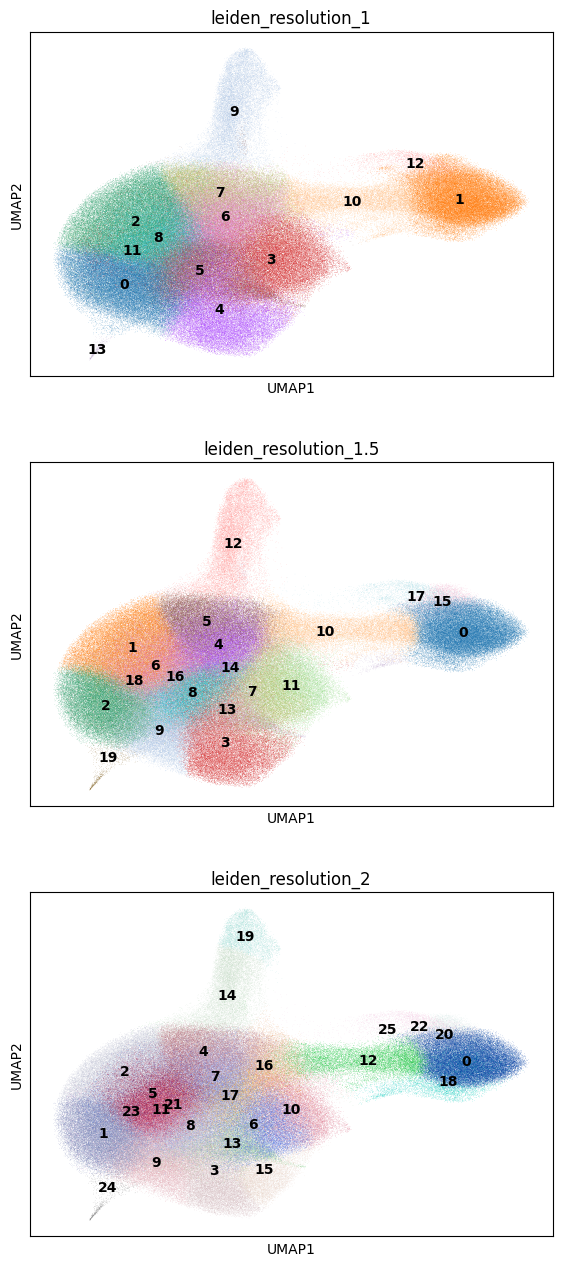

In [7]:
sc.pl.umap(adata, color=['leiden_resolution_1','leiden_resolution_1.5','leiden_resolution_2'], legend_loc='on data',use_raw=False, ncols=1)

In [24]:
[x for x in adata.var_names if re.search('HLA',x )]


['HHLA3', 'HHLA2', 'HHLA1']

In [31]:
adata

AnnData object with n_obs × n_vars = 373961 × 18082
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'celltype.l1', 'celltype.l1.score', 'celltype.l2', 'celltype.l2.score', 'celltype.l3', 'celltype.l3.score', 'chip_id', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pool_id', 'sampleID', 'well_id', 'celltypist_l1', 'celltypist_l2', 'celltypist_l3', 'predicted_doublet', 'doublet_score', 'age_enrollment', 'biological_sex', 'subject_guid', 'race', 'cmv_status', 'cmv_index', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_2', 'leiden', 'leiden_resolution_1', 'leiden_resolution_1.5', 'leiden_resolution_2'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'umap', 'rank_genes_groups', 'leiden_resolution_1_colors', 'leiden_resolution_1.5_colors', 'leiden_resolution_2_colors', 'celltypist_l3_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    obsp: 'connectivities', 'distances'

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


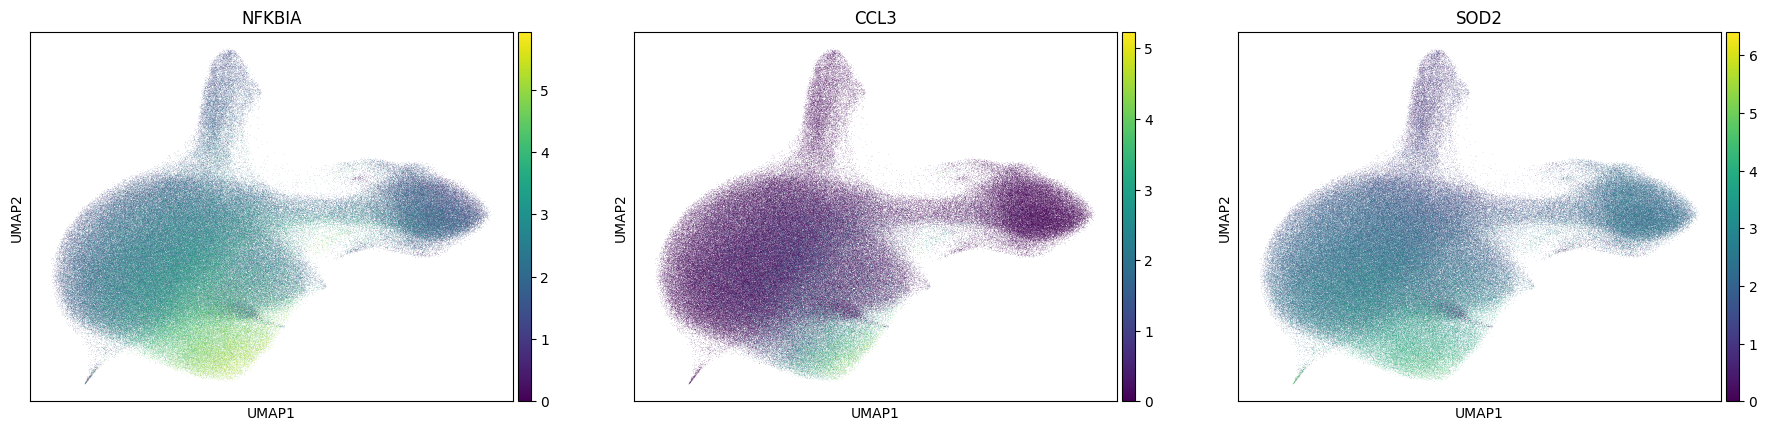

In [32]:
sc.pl.umap(adata, color=['NFKBIA','CCL3','SOD2'],use_raw=False, ncols=3)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


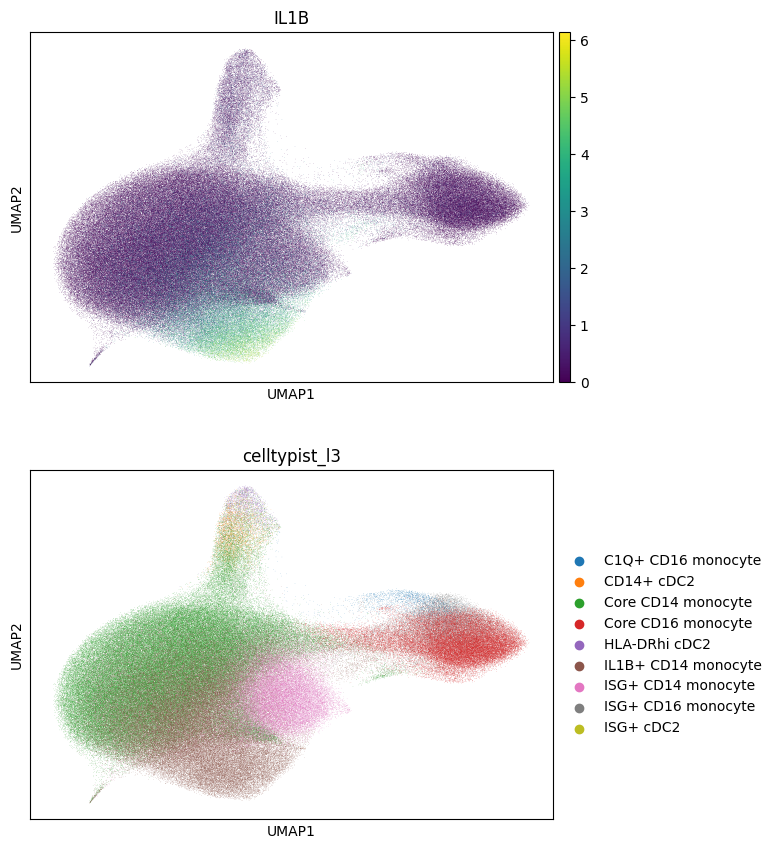

In [8]:
sc.pl.umap(adata, color=['IL1B','celltypist_l3'],use_raw=False, ncols=1)

In [9]:
sc.tl.rank_genes_groups(adata, 'leiden_resolution_2', use_raw=False,method='t-test')

/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

/tmp/ipykernel_77463/4263555102.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby('group').head(20).reset_index(drop=True)
/tmp/ipykernel_77463/4263555102.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby('group')


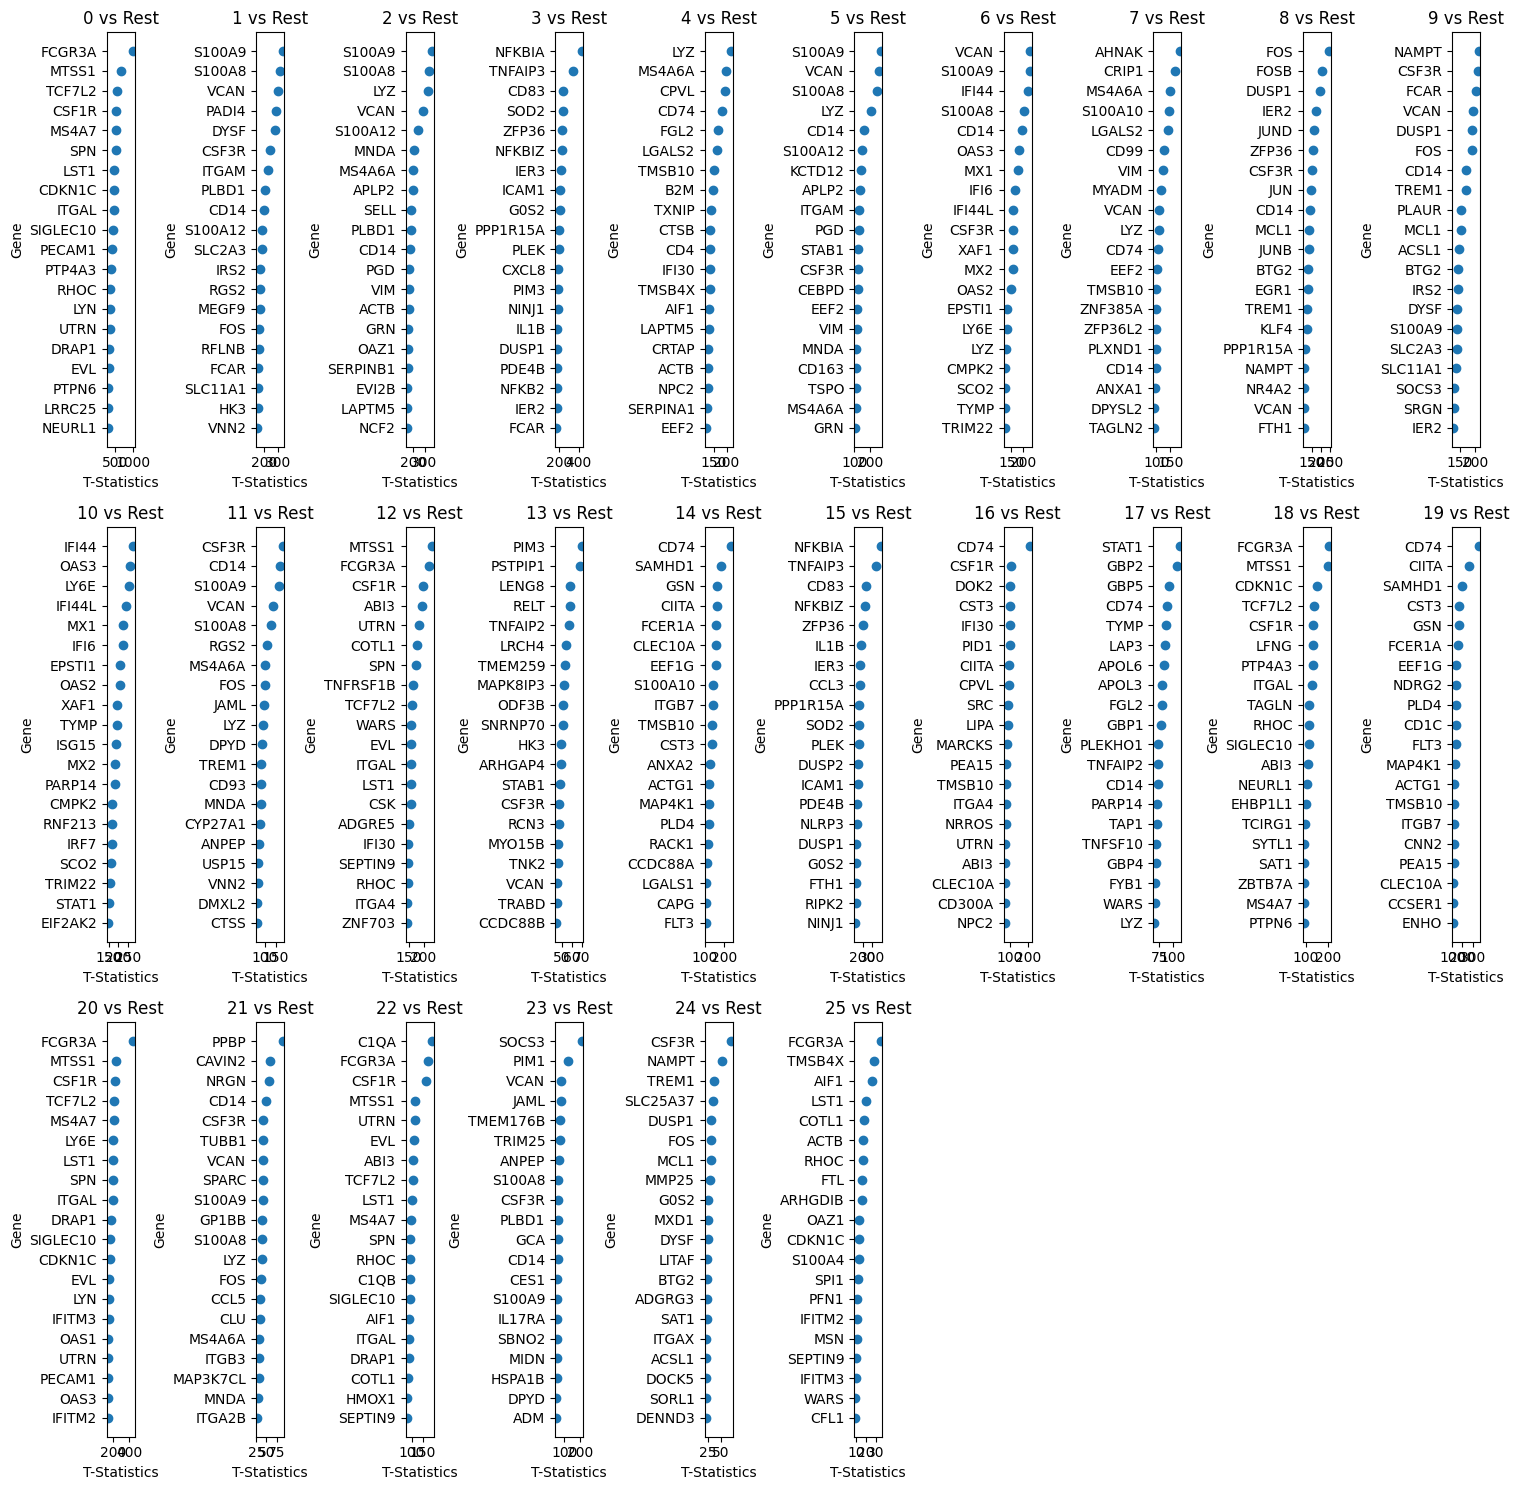

In [10]:
df = sc.get.rank_genes_groups_df(adata, group=None)
df = df.groupby('group').head(20).reset_index(drop=True)
groups = df.groupby('group')

n_groups = len(groups)
n_cols = 10
n_rows = math.ceil(n_groups / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

if n_rows == 1:
    axs = axs.reshape(1, -1)

for ax in axs.flat:
    ax.set_visible(False)

for i, (name, group) in enumerate(groups):
    row, col = divmod(i, n_cols)
    ax = axs[row, col]
    ax.set_visible(True)
    ax.scatter(group['scores'], group['names'])
    ax.invert_yaxis()
    ax.set_title(str(name) + " vs Rest")
    ax.set_xlabel('T-Statistics')
    ax.set_ylabel('Gene')

plt.tight_layout()